<a href="https://colab.research.google.com/github/Blusooyeon/Dacon/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98CV5_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

keras cnn 모델 사용

In [ ]:
import time
import random
import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf


from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘1/submission.csv')

letter 속에 digit 가 숨어있는 이미지

우리는 숫자를 예측해야한다.

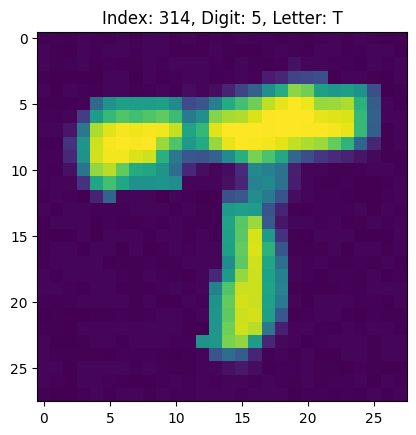

In [ ]:
# 이미지 확인
import random

idx = random.randint(0, 2048)
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [ ]:
# 모델 설계, 훈련

def one_hot_encoder(x): # 1개만 Hot(True)이고 나머지는 Cold(False) -> One hot endoding
    y = np.zeros((len(x), len(np.unique(x)))) # x의 길이만큼 모든 값이 0인 벡터 생성. np.unique(x) : x의 중복된 성분을 제외한 배열 반환
    for i, num in enumerate(x):
        y[i][num] = 1 # Label에 해당하는 인덱스에 1 입력
    return y

# CNN은 이미지 파일을 그대로 받는다.(28*28, 1채널) 훈련 파일을 이렇게 이미지 파일이 나열된 벡터로 만들어야 CNN에서 잘 처리할 수 있다.
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28,28,1) # shape 변경 (784크기가 6만개)

# 픽셀 값을 0~1 사이 값으로 변환 (너무 큰 값이 들어가면 함수의 계수들이 작아질 위험이 생김(0.0000023 등) -> 계수들의 학습이 불안정해짐.)
# 정규화의 목적 -> input의 범위와 output의 크기를 맞춰주기 위함 -> 계산 과정에서 생기는 위험 줄임)
x_train = x_train / 255 # 입력 데이터의 최대값이 255라 255로 나눠주는 것

# Label의 원-핫 인코딩 실행(배열 train_label을 벡터로 만들어줌 -> 이렇게 만들고 학습하면 잘됨. 분류 문제에서는 거의 one hot encording을 수행한다.)
y_train = one_hot_encoder(train['digit']) # 결과값(답안)을 one-hot encoder 기법으로 {1,0,0,...} 꼴의 벡터들의 리스트로 생성.

In [ ]:
# 성능을 높이는데, 이미지 데이터 증강이 중요해보였음

datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2)

#다양하게 진행한다고 해서 성능이 높아지는 것은 아님


In [ ]:
# cnn 모델 구축
# 이미지데이터 딥러닝 학습에서 가장 많이 사용되는 reLu 함수 사용
def create_cnn_model(x_train):

# 입력 데이터 가공
  inputs = tf.keras.layers.Input(x_train.shape[1:]) # 입력 데이터를 뽑아낸다.

  bn = tf.keras.layers.BatchNormalization()(inputs) # BatchNormalization : 배치 정규화. 스케일을 조정해 학습시 일어나는 왜곡 현상을 보정해줌. 안정적인 학습을 가능하게 해줘 높은 학습률로 학습 시킬 수 있게 해준다.
  conv = tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, padding='same', activation='relu')(bn)  # 배치 정규화한 입력 데이터를 2차원 배열 컨볼루전 연산. 커널 개수가 128개로 하고(커널을 8개로 할 때 보다 더많은 특징을 잡을 수 있다.) 커널 사이즈는 5*5사이즈로 한다.
  bn = tf.keras.layers.BatchNormalization()(conv) #컨볼루전 연산한 것을 또다시 배치 정규화.
  conv = tf.keras.layers.Conv2D(16, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 배치 정규화한 것을 또다시 컨볼루전 연산한다.
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling 레이어(이미지 학습할 때 많이 사용. MaxPooling2D : 이미지 크기를 줄여주는 함수. (2*2)단위로 이미지를 축소해서 쓴다.

  bn = tf.keras.layers.BatchNormalization()(inputs) # BatchNormalization : 배치 정규화. 스케일을 조정해 학습시 일어나는 왜곡 현상을 보정해줌. 안정적인 학습을 가능하게 해줘 높은 학습률로 학습 시킬 수 있게 해준다.
  conv = tf.keras.layers.Conv2D(32, kernel_size=2, strides=1, padding='same', activation='relu')(bn)  # 배치 정규화한 입력 데이터를 2차원 배열 컨볼루전 연산. 커널 개수가 128개로 하고(커널을 8개로 할 때 보다 더많은 특징을 잡을 수 있다.) 커널 사이즈는 5*5사이즈로 한다.
  bn = tf.keras.layers.BatchNormalization()(conv) #컨볼루전 연산한 것을 또다시 배치 정규화.
  conv = tf.keras.layers.Conv2D(32, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 배치 정규화한 것을 또다시 컨볼루전 연산한다.
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling 레이어(이미지 학습할 때 많이 사용. MaxPooling2D : 이미지 크기를 줄여주는 함수. (2*2)단위로 이미지를 축소해서 쓴다.

  bn = tf.keras.layers.BatchNormalization()(inputs) # BatchNormalization : 배치 정규화. 스케일을 조정해 학습시 일어나는 왜곡 현상을 보정해줌. 안정적인 학습을 가능하게 해줘 높은 학습률로 학습 시킬 수 있게 해준다.
  conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)  # 배치 정규화한 입력 데이터를 2차원 배열 컨볼루전 연산. 커널 개수가 128개로 하고(커널을 8개로 할 때 보다 더많은 특징을 잡을 수 있다.) 커널 사이즈는 5*5사이즈로 한다.
  bn = tf.keras.layers.BatchNormalization()(conv) #컨볼루전 연산한 것을 또다시 배치 정규화.
  conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 배치 정규화한 것을 또다시 컨볼루전 연산한다.
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling 레이어(이미지 학습할 때 많이 사용. MaxPooling2D : 이미지 크기를 줄여주는 함수. (2*2)단위로 이미지를 축소해서 쓴다.

# 축소한 것을 앞서 한 것처럼 배치 정규화, 컨볼루전 연산을 거친 뒤 마지막에 MaxPooling 레이어를 적용해 크기를 줄임으로써 데이터를 학습하기 편하게 가공해준다.
  bn = tf.keras.layers.BatchNormalization()(pool) # 배치 정규화.
  conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 컨볼루전 연산
  bn = tf.keras.layers.BatchNormalization()(conv) # 배치 정규화
  conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 컨볼루전 연산
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling

  flatten = tf.keras.layers.Flatten()(pool)

# 배치 정규화를 통해 안정적인 데이터로 만들어준다.
  bn = tf.keras.layers.BatchNormalization()(flatten)
# Dense Layer을 사용해 완전 연결 계층으로 생성 (Fully-Connected Layer). Dense : 입,출력을 모두 연결하는 레이어
  dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

# 출력
  bn = tf.keras.layers.BatchNormalization()(dense) # 배치 정규화
  outputs = tf.keras.layers.Dense(10, activation='softmax')(bn) # 배치 정규화한 것을 완전 연결 계층으로 만든다.

# 모델 생성
  model = tf.keras.models.Model(inputs=inputs, outputs=outputs) # 가공한 입, 출력 파일을 넣어 모델 생성

  return model

In [ ]:
model = create_cnn_model(x_train) # 모델 만들기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        16448     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0   

In [ ]:
# learning rate 조절
lr = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    x_train, y_train, test_size = 0.1)

history = model.fit(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs,
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2),
    callbacks=[lr],
    verbose=0
)


In [ ]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')

model_json = model.to_json()
with open(f"model.json", "w") as json_file :
    json_file.write(model_json)

In [ ]:
# 예측
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
pred = np.argmax(model.predict(X_test), axis=1)


640/640 [==============================] - 1s 2ms/step


In [ ]:
sub.digit = pred
sub.to_csv('CV5.csv', index=False)
